https://github.com/Ruiyang-061X/TSN


https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

## Imports

In [0]:
#!python3 '/content/drive/My Drive/DL Internship/TSN/train.py' --dataset '/content/drive/My Drive/DL Internship/Dataset(videos)/cropped videos' --modality RGB --trainset YOUR_TRAIN_VIDEO_LIST --validationset YOUR_VALIDATION_VIDEO_LIST --base_model BNInception --n_segment 3 --consensus_type avg --dropout 0.8 --epoch 80 --batch_size 4 --lr 0.001 --lr_step 30 60 --clip_gradient 20

#n = count_frames('/content/drive/My Drive/DL Internship/Dataset(videos)/cropped videos/Waving both hands/VID1.mp4')
#VideoRecord('/content/drive/My Drive/DL Internship/Dataset(videos)/cropped videos/Waving both hands/VID1.mp4', n, "Waving both hands")


In [0]:
"""
weight_path = '/content/drive/My Drive/TSN/bn_inception-9f5701afb96c8044.pth'
weight_fixed_path = '/content/drive/My Drive/TSN/bn_inception-9f5701afb96c8044_fixed.pth'
state_dict = torch.load(weight_path)
# weight_path = 'https://yjxiong.blob.core.windows.net/models/bn_inception-9f5701afb96c8044.pth'
pbar = tqdm(total=len(state_dict.items()))
for name, weights in state_dict.items():
  pbar.update(1)
  if 'bn' in name :
    state_dict[name] = weights.squeeze(0)
    torch.save(state_dict,weight_fixed_path)
pbar.close()
"""

"\nweight_path = '/content/drive/My Drive/TSN/bn_inception-9f5701afb96c8044.pth'\nweight_fixed_path = '/content/drive/My Drive/TSN/bn_inception-9f5701afb96c8044_fixed.pth'\nstate_dict = torch.load(weight_path)\n# weight_path = 'https://yjxiong.blob.core.windows.net/models/bn_inception-9f5701afb96c8044.pth'\npbar = tqdm(total=len(state_dict.items()))\nfor name, weights in state_dict.items():\n  pbar.update(1)\n  if 'bn' in name :\n    state_dict[name] = weights.squeeze(0)\n    torch.save(state_dict,weight_fixed_path)\npbar.close()\n"

In [0]:
"""
def count_frames_manual(video):
	total = 0
	while True:
		(grabbed, frame) = video.read()
		if not grabbed:
			break
		total += 1
	return total

def count_frames(path, override=False):
	video = cv2.VideoCapture(path)
	total = 0
	if override:
		total = count_frames_manual(video)
	else:
		try:
			total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
		except:
			total = count_frames_manual(video)
	video.release()
	return total

"""

'\ndef count_frames_manual(video):\n\ttotal = 0\n\twhile True:\n\t\t(grabbed, frame) = video.read()\n\t\tif not grabbed:\n\t\t\tbreak\n\t\ttotal += 1\n\treturn total\n\ndef count_frames(path, override=False):\n\tvideo = cv2.VideoCapture(path)\n\ttotal = 0\n\tif override:\n\t\ttotal = count_frames_manual(video)\n\telse:\n\t\ttry:\n\t\t\ttotal = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))\n\t\texcept:\n\t\t\ttotal = count_frames_manual(video)\n\tvideo.release()\n\treturn total\n\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import argparse
import time
from torch.utils.data import DataLoader
from torch.backends import cudnn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import nn
import torch
from torch.utils.data import Dataset
from easydict import EasyDict
import math
import random
import numpy as np
from PIL import Image, ImageOps
from torchvision import transforms
import cv2
import torchvision
import torch.utils.model_zoo as model_zoo
import yaml
from tqdm import tqdm
import csv
import glob
import os.path
from subprocess import call
import matplotlib.pyplot as plt

from datetime import datetime


In [0]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Final Models/TSN')
#import tf_model_zoo
from transform import *
#from tsn import TSN
#from dataset import TSNDataset
from tf_model_zoo.bninception.layer_factory import get_basic_layer, parse_expr

## Extract code

In [0]:
def get_video_parts(video_path):
    """Given a full path to a video, return its parts."""
    parts = video_path.split('/')
    filename = parts[-1]
    filename_no_ext = filename.split('.')[0]
    classname = parts[-2]
    train_or_test = parts[-3]
    return train_or_test, classname, filename_no_ext, filename

In [0]:
"""
video_data = '/content/drive/My Drive/Final Models/Merged  Dataset/train_test/'
if not os.path.exists(video_data+'dataset/'):
    os.mkdir(video_data+'dataset')
if not os.path.exists(video_data+'dataset/train'):
    os.mkdir(video_data+'dataset/train')
if not os.path.exists(video_data+'dataset/test'):
    os.mkdir(video_data+'dataset/test')

"""

def get_nb_frames_for_video(video_parts):
    """Given video parts of an (assumed) already extracted video, return
    the number of frames that were extracted."""
    train_or_test, classname, filename_no_ext, _ = video_parts
    generated_files = glob.glob(video_data+'dataset/'+train_or_test + '/' + classname + '/' +
                                filename_no_ext + '/*.jpg')
    return len(generated_files)

def check_already_extracted(video_parts):
    """Check to see if we created the -0001 frame of this file."""
    train_or_test, classname, filename_no_ext, _ = video_parts
    return bool(os.path.exists(video_data+'dataset/'+train_or_test + '/' + classname +
                               '/' + filename_no_ext + '/img_0001.jpg'))

def extract_files(video_data):
    data_file = []
    folders = [video_data+'test/']
    for folder in folders:
        class_folders = glob.glob(folder + '*')
        for vid_class in class_folders:
            class_files = glob.glob(vid_class + '/*.mp4')
            for video_path in class_files:
                # Get the parts of the file.
                video_parts = get_video_parts(video_path)
                train_or_test, classname, filename_no_ext, filename = video_parts

                if not check_already_extracted(video_parts):
                    # Now extract it.
                    if not os.path.exists(video_data+'dataset/'+train_or_test + '/' + classname):
                      os.mkdir(video_data+'dataset/'+train_or_test + '/' + classname)

                    if not os.path.exists(video_data+'dataset/'+train_or_test + '/' + classname + '/' +filename_no_ext):
                      os.mkdir(video_data+'dataset/'+train_or_test + '/' + classname + '/' +filename_no_ext)
                    src = video_data+train_or_test + '/' + classname + '/' + filename
                    dest = video_data+'dataset/'+train_or_test + '/' + classname + '/' +filename_no_ext + '/img_%04d.jpg'
                    call(["ffmpeg", "-i", src, dest])

                # Now get how many frames it is.
                nb_frames = get_nb_frames_for_video(video_parts)

                data_file.append([train_or_test, classname, filename_no_ext, nb_frames])

                print("Generated %d frames for %s" % (nb_frames, filename_no_ext))
              
                
    with open(video_data+'dataset/'+'data_file.csv', 'w') as fout:
        writer = csv.writer(fout)
        writer.writerows(data_file)

    print("Extracted and wrote %d video files." % (len(data_file)))


In [0]:
#extract_files(video_data)

In [7]:
# Check dataset
video_data = '/content/drive/My Drive/Final Models/Merged  Dataset/train_test/'
folders = [video_data+'dataset/train/', video_data+'dataset/test/']
for folder in folders:
    class_folders = glob.glob(folder + '*') # Abuse
    for vid_class in class_folders:
        class_files = glob.glob(vid_class + '/*') # Abuse001
        for video_path in class_files:
            img = glob.glob('/content/drive/My Drive/Final Models/Merged  Dataset/train_test/dataset/train/Assault/Assault007_x264_28' + '/*')
            print("Generated ", video_path, len(img))
            break
        break
    break
                

Generated  /content/drive/My Drive/Final Models/Merged  Dataset/train_test/dataset/train/Shoplifting/Shoplifting001_x264_15 60


## Dataset file

In [0]:
class VideoRecord():

    def __init__(self, path, n_frame, label):
        self.path = path
        self.n_frame = n_frame
        self.label = label

In [0]:

class TSNDataset(Dataset):

    def __init__(self, video_list_path, modality='RGB', train=True, n_segment=3, new_length=1, random_shift=True, tranform=None):
        self.video_list_path = video_list_path
        self.modality = modality
        self.train = train
        self.n_segment = n_segment
        self.new_length = new_length
        self.random_shift = random_shift
        self.tranform = tranform
        if self.modality == 'RGBDiff':
            self.new_length += 1
        self._parse_video_list()

    def _parse_video_list(self):
        self.video_record_list = []
        folders = os.listdir(self.video_list_path)
        classes = []
        for i, folder in enumerate(folders):
          files = os.listdir(self.video_list_path+"/"+folder)
          classes.append([i+1, folder])
          for filename in files:
              name = os.path.join(self.video_list_path+"/"+folder, filename)
              self.video_record_list.append(VideoRecord(name, len(glob.glob(name+'*.jpg')), i+1))
        with open(self.video_list_path+'labels_file.csv', 'w') as fout:
            writer = csv.writer(fout)
            writer.writerows(classes)

    def _get_segment_indice(self, video_record):
        if video_record.n_frame > self.n_segment + self.new_length - 1:
            stride = (video_record.n_frame - self.new_length + 1) / float(self.n_segment)
            indice = np.array([int(stride * i + stride / 2.0) for i in range(self.n_segment)])
        else:
            indice = np.zeros((self.n_segment), dtype=np.int)

        return indice + 1

    def _get_random_shift_segment_indice(self, video_record):
        duration = (video_record.n_frame - self.new_length + 1) // self.n_segment
        if duration > 0:
            indice = np.multiply(range(self.n_segment), duration) + np.random.randint(duration, size=self.n_segment)
        elif video_record.n_frame > self.n_segment:
            indice = np.sort(np.random.randint(video_record - self.new_length + 1, size=self.n_segment))
        else:
            indice = np.zeros((self.n_segment))
        indice = indice.astype(np.int)

        return indice + 1

    def _get_validation_segment_indice(self, video_record):
        stride = (video_record.n_frame - self.new_length + 1) / float(self.n_segment)
        indice = np.array([int(stride * i + stride / 2.0) for i in range(self.n_segment)])

        return indice + 1

    def _load_image(self, path, indice):
        if self.modality == 'RGB' or self.modality == 'RGBDiff':

            return [Image.open(os.path.join(path, 'img_{:04d}.jpg'.format(indice))).convert('RGB')]
        elif self.modality == 'Flow':
            flow_x = Image.open(os.path.join(path, 'flow_x_{:04d}.jpg'.format(indice))).convert('L')
            flow_y = Image.open(os.path.join(path, 'flow_y_{:04d}.jpg'.format(indice))).convert('L')

            return [flow_x, flow_y]

    def __getitem__(self, index):
        video_record = self.video_record_list[index]
        if self.train:
            segment_indice = self._get_random_shift_segment_indice(video_record) if self.random_shift else self._get_segment_indice(video_record)
        else:
            segment_indice = self._get_validation_segment_indice(video_record)
        
        image = []
        for i in segment_indice:
            for j in range(self.new_length):
                tmp = self._load_image(video_record.path, i)
                image += tmp
                if i < video_record.n_frame:
                    i += 1

        if self.tranform is not None:
            image = self.tranform(image)

        return image, video_record.label

    def __len__(self):

        return len(self.video_record_list)

## Classes

In [0]:

class BNInception(nn.Module):
    def __init__(self, model_path='/content/drive/My Drive/Final Models/TSN/tf_model_zoo/bninception/bn_inception.yaml', num_classes=25,
                       weight_url='/content/drive/My Drive/Final Models/TSN/bn_inception-9f5701afb96c8044_fixed.pth'):
        super(BNInception, self).__init__()
        manifest = yaml.load(open('/content/drive/My Drive/Final Models/TSN/tf_model_zoo/bninception/bn_inception.yaml'))
        layers = manifest['layers']

        self._channel_dict = dict()

        self._op_list = list()
        for l in layers:
            out_var, op, in_var = parse_expr(l['expr'])
            
            if op != 'Concat':
                id, out_name, module, out_channel, in_name = get_basic_layer(l,
                                                                3 if len(self._channel_dict) == 0 else self._channel_dict[in_var[0]],
                                                                             conv_bias=True)
                
                self._channel_dict[out_name] = out_channel
                setattr(self, id, module)
                self._op_list.append((id, op, out_name, in_name))
            else:
                self._op_list.append((id, op, out_var[0], in_var))
                channel = sum([self._channel_dict[x] for x in in_var])
                self._channel_dict[out_var[0]] = channel
        print("Model's state_dict:")
        print("Model's state_dict:")
        
        # //content/drive/My Drive/Final Models/TSN/bn_inception-9f5701afb96c8044_fixed.pth
        #for param_tensor in self.state_dict():
          #print(param_tensor, "\t", self.state_dict()[param_tensor].size())
        
        #print("\n\n\n\n")
        
        #for param_tensor in torch.load(weight_url):
        #  print(param_tensor, "\t")
        #print("\n\n\npre trained")
        #for param_tensor in torch.load('/content/drive/My Drive/Final Models/TSN/bn_inception-9f5701afb96c8044.pth'):
        #  print(param_tensor, "\t")

        self.load_state_dict(torch.load(weight_url))
        
        #self.load_state_dict(torch.utils.model_zoo.load_url(weight_url), strict=False)

    def forward(self, input):
        data_dict = dict()
        data_dict[self._op_list[0][-1]] = input

        def get_hook(name):

            def hook(m, grad_in, grad_out):
                print(name, grad_out[0].data.abs().mean())

            return hook
        for op in self._op_list:
            if op[1] != 'Concat' and op[1] != 'InnerProduct':
                data_dict[op[2]] = getattr(self, op[0])(data_dict[op[-1]])
                # getattr(self, op[0]).register_backward_hook(get_hook(op[0]))
            elif op[1] == 'InnerProduct':
                x = data_dict[op[-1]]
                data_dict[op[2]] = getattr(self, op[0])(x.view(x.size(0), -1))
            else:
                try:
                    data_dict[op[2]] = torch.cat(tuple(data_dict[x] for x in op[-1]), 1)
                except:
                    for x in op[-1]:
                        print(x,data_dict[x].size())
                    raise
        return data_dict[self._op_list[-1][2]]


In [0]:
class InceptionV3(BNInception):
    def __init__(self, model_path='model_zoo/bninception/inceptionv3.yaml', num_classes=101,
                 weight_url='https://yjxiong.blob.core.windows.net/models/inceptionv3-cuhk-0e09b300b493bc74c.pth'):
        super(InceptionV3, self).__init__(model_path=model_path, weight_url=weight_url, num_classes=num_classes)


In [0]:
class ConsensusFunction(torch.autograd.Function):
    """
    def __init__(self, consensus_type, dim=1):
        self.consensus_type = consensus_type
        self.dim = dim
        self.shape = None
    """

    @staticmethod
    def forward(ctx, x):
        shape = x.size()
        ctx.save_for_backward(x)
        """
        if self.consensus_type == 'avg':
            x = x.mean(dim=self.dim, keepdim=True)
        if self.consensus_type == 'identity':
            x = x
        """
        x = x.mean(dim=1, keepdim=True)

        return x

    @staticmethod
    def backward(ctx, dout):
        """
        if self.consensus_type == 'avg':
            din = dout.expand(self.shape) / float(self.shape[self.dim])
        if self.consensus_type == 'identity':
            din = dout
        """
        x, = ctx.saved_tensors
        shape = x.size()
        din = dout.expand(shape) / float(shape[1])
        return din


In [0]:

class Consensus(nn.Module):

    def __init__(self, consensus_type, dim=1):
        super(Consensus, self).__init__()
        self.consensus_type = consensus_type
        self.dim = dim
    def forward(self, x):
        relu = ConsensusFunction.apply
        return relu(x)
        #return ConsensusFunction(self.consensus_type, self.dim)(x)


In [0]:

class TSN(nn.Module):

    def __init__(self, base_model='BNInception', n_class=101, consensus_type='avg', before_softmax=True, dropout=0.8, n_crop=1, modality='RGB', n_segment=3, new_length=1):
        super(TSN, self).__init__()
        self.base_model = base_model
        self.n_class = n_class
        self.consensus_type = consensus_type
        self.before_softmax = before_softmax
        self.dropout = dropout
        self.n_crop = n_crop
        self.modality = modality
        self.n_segment = n_segment
        self.new_length = new_length

        print('''
        Initializing TSN with base model: {}
        TSN Configuration:
            modality:           {}
            n_segment:          {}
            new_length:         {}
            consensus_type:     {}
            dropout:            {}
        '''.format(self.base_model, self.modality, self.n_segment, self.new_length, self.consensus_type, self.dropout))

        self._prepare_base_model()
        self._prepare_tsn()
        if self.modality == 'RGBDiff':
            print('Converting the imagenet model to RGBDiff init model')
            self._construct_rgbdiff_model()
            print('Done')
        if self.modality == 'Flow':
            print('Converting the imagenet model to flow init model')
            self._construct_flow_model()
            print('Done')
        self.consensus = Consensus(self.consensus_type)
        if not self.before_softmax:
            self.softmax = nn.Softmax()

    def _prepare_base_model(self):
        if 'vgg' in self.base_model or 'resnet' in self.base_model:
            self.base_model = getattr(torchvision.models, self.base_model)(True)
            self.base_model.last_layer_name = 'fc'
            return
        if self.base_model == 'BNInception':
            #self.base_model = getattr(tf_model_zoo, self.base_model)()
            self.base_model = BNInception()
            self.base_model.last_layer_name = 'fc'
            return
        if 'inception' in self.base_model:
            self.base_model = getattr(tf_model_zoo, self.base_model)()
            self.base_model.last_layer_name = 'classif'
            return

    def _prepare_tsn(self):
        in_features = getattr(self.base_model, self.base_model.last_layer_name).in_features
        if self.dropout == 0:
            setattr(self.base_model, self.base_model.last_layer_name, nn.Linear(in_features=in_features, out_features=self.n_class))
            self.new_linear = None
        else:
            setattr(self.base_model, self.base_model.last_layer_name, nn.Dropout(p=self.dropout))
            self.new_linear = nn.Linear(in_features=in_features, out_features=self.n_class)

        if self.new_linear is None:
            nn.init.normal_(getattr(self.base_model, self.base_model.last_layer_name).weight, 0, 0.001)
            nn.init.constant_(getattr(self.base_model, self.base_model.last_layer_name).bias, 0)
        else:
            nn.init.normal_(self.new_linear.weight, 0, 0.001)
            nn.init.constant_(self.new_linear.bias, 0)

    def _construct_rgbdiff_model(self):
        modules = list(self.base_model.modules())
        first_conv_index = list(filter(lambda i: isinstance(modules[i], nn.Conv2d), range(len(modules))))[0]
        conv_layer = modules[first_conv_index]
        container = modules[first_conv_index - 1]

        ps = [i.clone() for i in conv_layer.parameters()]
        kernel_size = ps[0].size()
        new_kernel_size=  kernel_size[ : 1] + (3 * self.new_length, ) + kernel_size[2 : ]
        new_kernel = ps[0].data.mean(dim=1, keepdim=True).expand(new_kernel_size).contiguous()
        new_conv_layer = nn.Conv2d(in_channels=new_kernel_size[1], out_channels=conv_layer.out_channels, kernel_size=conv_layer.kernel_size, stride=conv_layer.stride, padding=conv_layer.padding, bias=True if len(ps) == 2 else False)
        new_conv_layer.weight.data = new_kernel
        if len(ps) == 2:
            new_conv_layer.bias.data = ps[1].data
        layer_name = list(container.state_dict())[0][ : -7]
        setattr(container, layer_name, new_conv_layer)

    def _construct_flow_model(self):
        modules = list(self.base_model.modules())
        first_conv_index = list(filter(lambda i: isinstance(modules[i], nn.Conv2d), range(len(modules))))[0]
        conv_layer = modules[first_conv_index]
        container = modules[first_conv_index - 1]

        ps = [i.clone() for i in conv_layer.parameters()]
        kernel_size = ps[0].size()
        new_kernel_size = kernel_size[: 1] + (2 * self.new_length,) + kernel_size[2:]
        new_kernel = ps[0].data.mean(dim=1, keepdim=True).expand(new_kernel_size).contiguous()
        new_conv_layer = nn.Conv2d(in_channels=2 * self.new_length, out_channels=conv_layer.out_channels, kernel_size=conv_layer.kernel_size, stride=conv_layer.stride, padding=conv_layer.padding, bias=True if len(ps) == 2 else False)
        new_conv_layer.weight.data = new_kernel
        if len(ps) == 2:
            new_conv_layer.bias.data = ps[1].data
        layer_name = list(container.state_dict())[0][: -7]
        setattr(container, layer_name, new_conv_layer)

    def train(self, mode=True):
        super(TSN, self).train(mode=mode)
        count = 0
        print('Freezing BatchNorm2D except the first one')
        for m in self.base_model.modules():
            if isinstance(m, nn.BatchNorm2d):
                count += 1
                if count >= 2:
                    m.eval()
                    m.weight.requires_grad = False
                    m.bias.requires_grad = False

    def forward(self, x):
        sample_len = (3 if self.modality == 'RGB' or self.modality == 'RGBDiff' else 2) * self.new_length
        
        if self.modality == 'RGBDiff':
            x = self._get_diff(x)
        
        x = self.base_model(x.view((-1, sample_len) + x.size()[-2 : ]))
        
        if self.dropout > 0:
            x = self.new_linear(x)
        if not self.before_softmax:
            x = self.softmax(x)
        x = x.view((-1, self.n_segment) + x.size()[1 : ])
        
        x = self.consensus(x)
        
        
        x = x.squeeze(1)

        return x

    def _get_diff(self, x):
        x = x.view((-1, self.n_segment, self.new_length + 1, 3) + x.size()[2 : ])
        new_x = x[ : , : , 1 : , : , : , : ].clone()
        for i in reversed(range(1, self.new_length + 1, 1)):
            new_x[ : , : , i - 1, : , : , : ] = x[ : , : , i , : , : , : ] - x[ : , : , i - 1 , : , : , : ]

        return new_x

## Model

In [0]:
args = EasyDict({
    "dataset":'videos',
    "modality": 'RGB',
    "trainset": '/content/drive/My Drive/Final Models/Merged  Dataset/train_test/dataset/train',
    "validationset": '/content/drive/My Drive/Final Models/Merged  Dataset/train_test/dataset/test',
    "base_model": 'BNInception',
    "n_segment": 3,
    "consensus_type": 'avg',
    "dropout": 0.5 ,
    "epoch": 20,
    "batch_size": 32,
    "lr": 0.001,
    "lr_step": [30, 60],
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "clip_gradient": 20,
    "print_every": 20,
    "validation_every": 5
})

In [0]:
cudnn.benchmark = True

if not os.path.exists('/content/drive/My Drive/Final Models/TSN/trained_model'):
    os.mkdir('/content/drive/My Drive/Final Models/TSN/trained_model')

if args.modality == 'RGB':
    new_length = 1
else:
    new_length = 5

if 'vgg' in args.base_model or 'resnet' in args.base_model:
    input_size = 224
    input_mean = [0.485, 0.456, 0.406]
    input_std = [0.229, 0.224, 0.225]
    if args.modality == 'Flow':
        input_mean = [0.5]
        input_std = [np.mean(input_std)]
    if args.modality == 'RGBDiff':
        input_mean = input_mean + [0] * 3 * new_length
        input_std = input_std + [np.mean(input_std) * 2] * 3 * new_length
if args.base_model == 'BNInception':
    input_size = 224
    input_mean = [104, 117, 128]
    input_std = [1]
    if args.modality == 'Flow':
        input_mean = [128]
    if args.modality == 'RGBDiff':
        input_mean = input_mean * (new_length + 1)
if 'inception' in args.base_model:
    input_size = 299
    input_mean = [0.5]
    input_std = [0.5]
crop_size = input_size
scale_size = input_size * 256 // 224
if args.modality == 'RGB':
    train_augmentation = transforms.Compose([GroupMultiScaleCrop(input_size, [1, 0.875, 0.75, 0.66]), GroupRandomHorizontalFlip(is_flow=False)])
if args.modality == 'RGBDiff':
    train_augmentation = transforms.Compose([GroupMultiScaleCrop(input_size, [1, 0.875, 0.75]), GroupRandomHorizontalFlip(is_flow=False)])
if args.modality == 'Flow':
    train_augmentation = transforms.Compose([GroupMultiScaleCrop(input_size, [1, 0.875, 0.75]), GroupRandomHorizontalFlip(is_flow=True)])

if args.modality != 'RGBDiff':
    normalize = GroupNormalize(input_mean, input_std)
else:
    normalize = IdentityTransform()

In [0]:
transform_trainset = transforms.Compose([train_augmentation, Stack(roll=args.base_model == 'BNInception'), ToTorchFormatTensor(div= args.base_model != 'BNInception'), normalize, ])
trainset = TSNDataset(video_list_path=args.trainset, modality=args.modality, train=True, n_segment=args.n_segment, new_length=new_length, random_shift=True, tranform=transform_trainset)
transform_validationset = transforms.Compose([GroupScale(scale_size), GroupCenterCrop(crop_size), Stack(roll=args.base_model == 'BNInception'), ToTorchFormatTensor(div= args.base_model != 'BNInception'), normalize, ])
validationset = TSNDataset(video_list_path=args.validationset, modality=args.modality, train=False, n_segment=args.n_segment, new_length=new_length, random_shift=False, tranform=transform_trainset)
trainset_loader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validationset, batch_size=args.batch_size, shuffle=False, pin_memory=True)

In [0]:
n_class = 25
#/content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_9_2.036.pth
# /content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_19_0.933.pth
#/content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_19_1.443.pth
#/content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_19_1.655.pth
#/content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_19_0.849.pth
#/content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_19_2.673.pth
#tsn = TSN(base_model=args.base_model, n_class=n_class, consensus_type=args.consensus_type, before_softmax=True, dropout=args.dropout, n_crop=1, modality=args.modality, n_segment=args.n_segment, new_length=new_length)
tsn = torch.load('/content/drive/My Drive/Final Models/TSN/trained_model/BNInception_videos_RGB_19_2.673.pth')
tsn = tsn.cuda()

In [19]:
loss_function = CrossEntropyLoss()
loss_function = loss_function.cuda()

first_conv_weight = []
first_conv_bias = []
normal_weight = []
normal_bias = []
bn = []
conv_count = 0
bn_count = 0
for m in tsn.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        ps = list(m.parameters())
        conv_count += 1
        if conv_count == 1:
            first_conv_weight += [ps[0]]
            if len(ps) == 2:
                first_conv_bias += [ps[1]]
        else:
            normal_weight += [ps[0]]
            if len(ps) == 2:
                normal_bias += [ps[1]]
    if isinstance(m, nn.Linear):
        ps = list(m.parameters())
        normal_weight += [ps[0]]
        if len(ps) == 2:
            normal_bias += [ps[1]]
    if isinstance(m, nn.BatchNorm1d):
        ps = list(m.parameters())
        bn += ps
    if isinstance(m, nn.BatchNorm2d):
        bn_count += 1
        if bn_count == 1:
            ps = list(m.parameters())
            bn += ps
optimize_policy = [
    {'name': 'first_conv_weight', 'params': first_conv_weight, 'lr_mult': 5 if args.modality == 'Flow' else 1, 'decay_mult': 1},
    {'name': 'first_conv_bias', 'params': first_conv_bias, 'lr_mult': 10 if args.modality == 'Flow' else 2, 'decay_mult': 0},
    {'name': 'normal_weight', 'params': normal_weight, 'lr_mult': 1, 'decay_mult': 1},
    {'name': 'normal_bias', 'params': normal_bias, 'lr_mult': 2, 'decay_mult': 0},
    {'name': 'BN scale/shift', 'params': bn, 'lr_mult': 1, 'decay_mult': 0},
]
for i in optimize_policy:
    print('group {} has {} parameters, lr_mult: {}, decay_mult: {}'.format(i['name'], len(i['params']), i['lr_mult'], i['decay_mult']))
optimizer = SGD(optimize_policy, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

group first_conv_weight has 1 parameters, lr_mult: 1, decay_mult: 1
group first_conv_bias has 1 parameters, lr_mult: 2, decay_mult: 0
group normal_weight has 69 parameters, lr_mult: 1, decay_mult: 1
group normal_bias has 69 parameters, lr_mult: 2, decay_mult: 0
group BN scale/shift has 2 parameters, lr_mult: 1, decay_mult: 0


In [0]:
class AverageMeter():

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(predicted_label, label, topk=(1, 5)):
    maxk = max(topk)
    _, predicted_label = predicted_label.topk(maxk, 1, True, True)
    predicted_label = predicted_label.t()
    correct = predicted_label.eq(label.view(1, -1).expand_as(predicted_label))

    result = []
    for i in topk:
        correct_i = correct[ : i].view(-1).float().sum(0)
        result += [correct_i / args.batch_size * 100.0]

    return result

In [0]:
def adjust_lr(optimizer, epoch, lr_step):
    decay = 0.1 ** (sum(epoch >= np.array(lr_step)))
    lr = args.lr * decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * param_group['lr_mult']
        param_group['weight_decay'] = args.weight_decay * param_group['decay_mult']

## Training

In [0]:
def validation():
    print('start validation...')
    loss_avg = AverageMeter()
    accuracy1_avg = AverageMeter()
    accuracy5_avg = AverageMeter()

    tsn.eval()
    for i, (input, label) in enumerate(validation_loader):
        input = input.cuda()
        label = label.cuda()
        predicted_label = tsn(input)
        loss = loss_function(predicted_label, label)
        accuracy1, accuracy5 = accuracy(predicted_label, label, topk=(1, 5))
        loss_avg.update(loss.item(), input.size(0))
        accuracy1_avg.update(accuracy1.item(), input.size(0))
        accuracy5_avg.update(accuracy5.item(), input.size(0))
    print('Validation result: Loss {:.3f} Accuracy@1 {:.3f} Accuracy@5 {:.3f}'.format(loss_avg.avg, accuracy1_avg.avg, accuracy5_avg.avg))
    tsn.train()
    accuracy_ = accuracy1_avg.avg

    return accuracy_, accuracy5_avg.avg, loss_avg.avg

In [0]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

from torchvision import models
#inputs = torch.randn(1,3,224,224)


In [25]:
print('start training...')
loss_list = []
val_loss_list = []
accuracy1_list =  []
accuracy5_list = []
val_accuracy1_list = []
val_accuracy5_list = []

for i in range(args.epoch):
    adjust_lr(optimizer, i, args.lr_step)

    data_time = AverageMeter()
    batch_time = AverageMeter()
    loss_avg = AverageMeter()
    accuracy1_avg = AverageMeter()
    accuracy5_avg = AverageMeter()

    end = time.time()
    start_time = datetime.now()
    for j, (input, label) in enumerate(trainset_loader):
        data_time.update(time.time() - end)
        tsn.zero_grad()
        input = input.cuda()
        label = label.cuda()
        predicted_label = tsn(input)
      

        g = make_dot(predicted_label, tsn.state_dict())
        g.view()
        break
        loss = loss_function(predicted_label, label)
        accuracy1, accuracy5 = accuracy(predicted_label, label, topk=(1, 5))
        loss_avg.update(loss.item(), input.size(0))
        accuracy1_avg.update(accuracy1.item(), input.size(0))
        accuracy5_avg.update(accuracy5.item(), input.size(0))
        loss.backward()
        if args.clip_gradient is not None:
            total_norm = nn.utils.clip_grad_norm_(tsn.parameters(), args.clip_gradient)
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if j % args.print_every == 0:
            print('Epoch: [{}/{}][{}/{}], lr {:.5f} Data {:.3f} ({:.3f}) Batch {:.3f} ({:.3f}) Loss {:.3f} ({:.3f}) Accuracy@1 {:.3f} ({:.3f}) Accuracy@5 {:.3f} ({:.3f})'.format(i, args.epoch, j, len(trainset_loader), optimizer.param_groups[-1]['lr'], data_time.val, data_time.avg, batch_time.val, batch_time.avg, loss_avg.val, loss_avg.avg, accuracy1_avg.val, accuracy1_avg.avg, accuracy5_avg.val, accuracy5_avg.avg))
    break
    #accuracy_, accuracy5_, val_loss = validation()
    if (i + 1) % args.validation_every == 0 or i == args.epoch - 1:
        accuracy_, accuracy5_, val_loss = validation()
        trained_model_name = '{}_{}_{}_{}_{:.3f}.pth'.format(args.base_model, args.dataset, args.modality, i, accuracy_)
        trained_model_path = '/content/drive/My Drive/Final Models/TSN/trained_model/' + trained_model_name
        print(trained_model_path)
        
        torch.save(tsn, trained_model_path)
        #torch.save(tsn.state_dict(), trained_model_path)
    end_time = datetime.now()
    
    #val_accuracy1_list.append(accuracy_)
    #val_accuracy5_list.append(accuracy5_)
    accuracy1_list.append(accuracy1_avg.avg)
    accuracy5_list.append(accuracy5_avg.avg)
    loss_list.append(loss_avg.avg)
    #val_loss_list.append(val_loss)
    # 1:14, 

    print("Time taken by one epoch", end_time-start_time)    

start training...
{139669409013336: 'base_model.conv1_7x7_s2.weight', 139669409013264: 'base_model.conv1_7x7_s2.bias', 139669409013120: 'base_model.conv1_7x7_s2_bn.weight', 139669409013048: 'base_model.conv1_7x7_s2_bn.bias', 139669409012976: 'base_model.conv1_7x7_s2_bn.running_mean', 139669409012904: 'base_model.conv1_7x7_s2_bn.running_var', 139669409012832: 'base_model.conv1_7x7_s2_bn.num_batches_tracked', 139669409012400: 'base_model.conv2_3x3_reduce.weight', 139669409012328: 'base_model.conv2_3x3_reduce.bias', 139669409012184: 'base_model.conv2_3x3_reduce_bn.weight', 139669409012112: 'base_model.conv2_3x3_reduce_bn.bias', 139669409012040: 'base_model.conv2_3x3_reduce_bn.running_mean', 139669409011968: 'base_model.conv2_3x3_reduce_bn.running_var', 139669409011896: 'base_model.conv2_3x3_reduce_bn.num_batches_tracked', 139669409011536: 'base_model.conv2_3x3.weight', 139669409011464: 'base_model.conv2_3x3.bias', 139669409011320: 'base_model.conv2_3x3_bn.weight', 139669409011248: 'base_m

In [0]:
!ls '/content/drive/My Drive/Final Models/Merged  Dataset/train_test/dataset/test/Stealing/Stealing107_x264_27'

img_0001.jpg  img_0025.jpg  img_0049.jpg  img_0073.jpg	img_0097.jpg
img_0002.jpg  img_0026.jpg  img_0050.jpg  img_0074.jpg	img_0098.jpg
img_0003.jpg  img_0027.jpg  img_0051.jpg  img_0075.jpg	img_0099.jpg
img_0004.jpg  img_0028.jpg  img_0052.jpg  img_0076.jpg	img_0100.jpg
img_0005.jpg  img_0029.jpg  img_0053.jpg  img_0077.jpg	img_0101.jpg
img_0006.jpg  img_0030.jpg  img_0054.jpg  img_0078.jpg	img_0102.jpg
img_0007.jpg  img_0031.jpg  img_0055.jpg  img_0079.jpg	img_0103.jpg
img_0008.jpg  img_0032.jpg  img_0056.jpg  img_0080.jpg	img_0104.jpg
img_0009.jpg  img_0033.jpg  img_0057.jpg  img_0081.jpg	img_0105.jpg
img_0010.jpg  img_0034.jpg  img_0058.jpg  img_0082.jpg	img_0106.jpg
img_0011.jpg  img_0035.jpg  img_0059.jpg  img_0083.jpg	img_0107.jpg
img_0012.jpg  img_0036.jpg  img_0060.jpg  img_0084.jpg	img_0108.jpg
img_0013.jpg  img_0037.jpg  img_0061.jpg  img_0085.jpg	img_0109.jpg
img_0014.jpg  img_0038.jpg  img_0062.jpg  img_0086.jpg	img_0110.jpg
img_0015.jpg  img_0039.jpg  img_0063.jpg  img_00

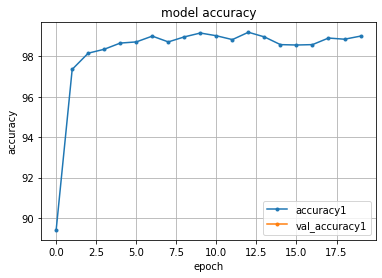

In [0]:
plt.plot(accuracy1_list, marker='.')
plt.plot(val_accuracy1_list, marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy1', 'val_accuracy1'], loc='lower right')
plt.savefig(os.path.join('/content/drive/My Drive/Final Models/TSN/result_new', 'model_accuracy1.png'))
plt.show()

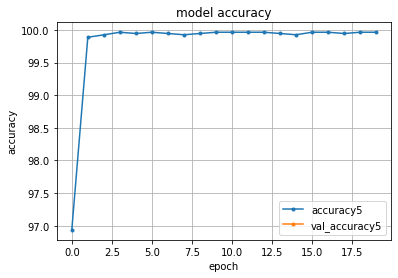

In [0]:
plt.plot(accuracy5_list, marker='.')
plt.plot(val_accuracy5_list, marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy5', 'val_accuracy5'], loc='lower right')
#plt.savefig('/content/drive/My Drive/Final Models/TSN/result_new', 'model_accuracy5.png')
plt.show()

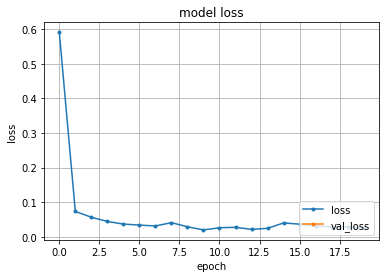

In [0]:
plt.plot(loss_list, marker='.')
plt.plot(val_loss_list, marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.savefig(os.path.join('/content/drive/My Drive/Final Models/TSN/result_new', 'model_loss.png'))
plt.show()